# Examples of CGAN-generated CREF

This notebook provides examples of CGAN-generated composite radar reflectivity (CREF) on 64-by-64-sized patches. A hail event was reported within the coverage of the patch. The CGAN outputs showed both variations and agreements compared to the HRRRv4 CREF field.

In [ ]:
# general tools
import os
import re
import sys
import time
import h5py
import random
from glob import glob

import numpy as np
from datetime import datetime, timedelta
from random import shuffle

In [2]:
# graph tools
import cmaps
import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from matplotlib import ticker
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

In [3]:
from scipy.spatial import cKDTree

In [4]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu

In [5]:
need_publish = False

# True: publication quality figures
# False: low resolution figures in the notebook

if need_publish:
    dpi_ = fig_keys['dpi']
else:
    dpi_ = 75

In [ ]:
# Cartopy map settings
scale_param = '10m' # 10m for publication quality
# US states and CAN-US boundary
PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')

cmap_pct, A = gu.precip_cmap()

**Lat/lon info + map 80-km gridded severe weather report to 3-km HRRR domain**

In [6]:
with h5py.File(save_dir+'HRRR_domain.hdf', 'r') as h5io:
    lon_3km = h5io['lon_3km'][...]
    lat_3km = h5io['lat_3km'][...]
    lon_80km = h5io['lon_80km'][...]
    lat_80km = h5io['lat_80km'][...]
    land_mask_80km = h5io['land_mask_80km'][...]
    land_mask_3km = h5io['land_mask_3km'][...]

shape_3km = lon_3km.shape
shape_80km = lon_80km.shape

indx_array = np.empty(shape_80km)
indy_array = np.empty(shape_80km)

gridTree = cKDTree(list(zip(lon_3km.ravel(), lat_3km.ravel()))) #KDTree_wraper(xgrid, ygrid)

for xi in range(shape_80km[0]):
    for yi in range(shape_80km[1]):
        
        temp_lon = lon_80km[xi, yi]
        temp_lat = lat_80km[xi, yi]
        
        dist, indexes = gridTree.query(list(zip(np.array(temp_lon)[None], np.array(temp_lat)[None])))
        indx_3km, indy_3km = np.unravel_index(indexes, shape_3km)
        
        indx_array[xi, yi] = indx_3km[0]
        indy_array[xi, yi] = indy_3km[0]

**Load the example**

In [7]:
filenames = glob('/glade/work/ksha/NCAR/GAN/example_batch_v4.npy')

temp_data = np.load(filenames[0], allow_pickle=True)[()]
file_info = temp_data['info']
data_gen = temp_data['data_gen']
data_input = temp_data['data_input']
data_output = temp_data['data_output']

print(file_info)

/glade/campaign/cisl/aiml/ksha/NCAR_batch_v4_temp/TESTv4_day181_neg_neg_pos_indx25_indy41_lead2.npy


In [8]:
indx = 25
indy = 41

indx_3km = int(indx_array[indx, indy])
indy_3km = int(indy_array[indx, indy])

lon_batch = lon_3km[indx_3km-32:indx_3km+32, indy_3km-32:indy_3km+32]
lat_batch = lat_3km[indx_3km-32:indx_3km+32, indy_3km-32:indy_3km+32]

In [9]:


edge_frame = [np.min(lon_batch)+0.16, np.max(lon_batch)-0.16, np.min(lat_batch)+0.2+0.1, np.max(lat_batch)-0.11-0.1]
edge_area = [np.min(lon_batch)-2.5, np.max(lon_batch)+2.5, np.min(lat_batch)-1.575, np.max(lat_batch)+1.575]

**Return CGAN-outputs to dBz unit**

In [10]:
norm_stats = np.load('/glade/work/ksha/NCAR/stats_allv4_80km_full_lead{}{}{}.npy'.format(2, 3, 4))
max_stats = np.load('/glade/work/ksha/NCAR/p90_allv4_80km_full_lead{}{}{}.npy'.format(2, 3, 4))

ix = 25
iy = 41

means = norm_stats[ix, iy, :, 0]
stds = norm_stats[ix, iy, :, 1]
max_vals = max_stats[ix, iy, :, 3]

f = 5*stds[0]*max_vals[0]
f_uh = stds[2]*max_vals[2]

**Figure**

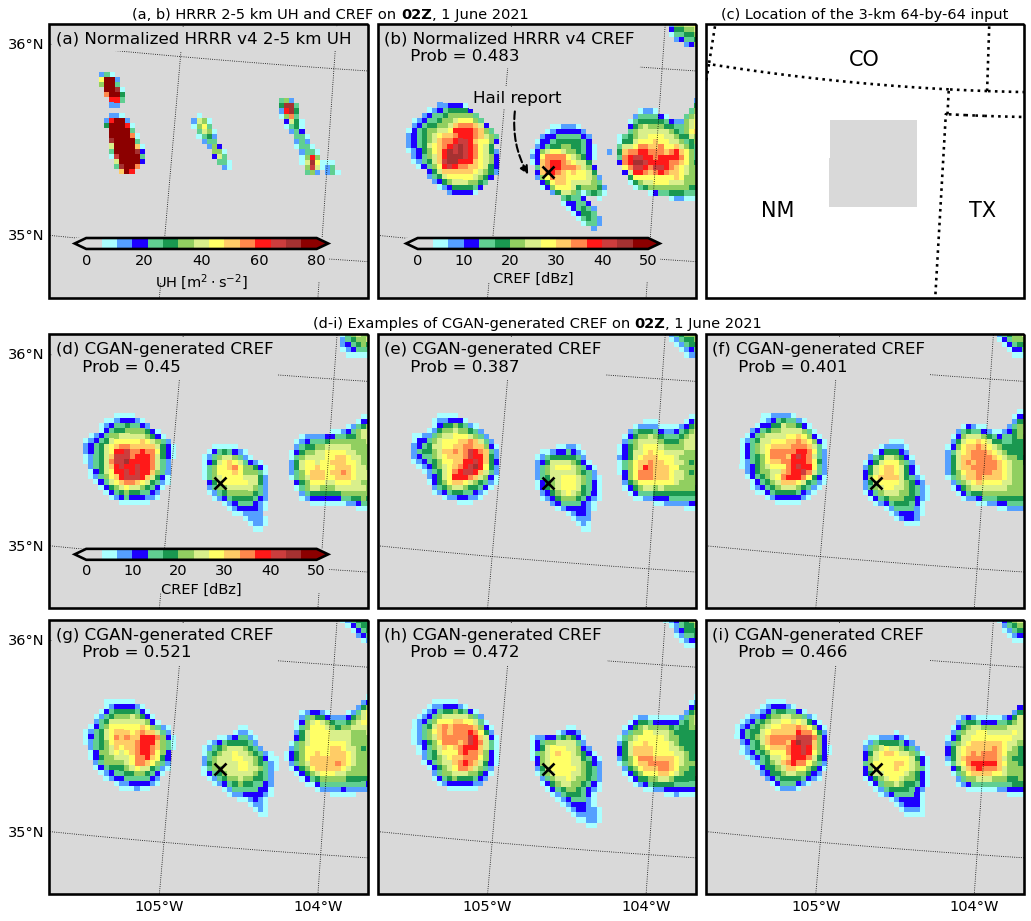

In [14]:
ind_pick = [0, 4, 1, 5, 2, 3]
probs = [0.483, 0.450, 0.387, 0.401, 0.521, 0.472, 0.466]

fig = plt.figure(figsize=(13, 11.675), dpi=dpi_)
gs = gridspec.GridSpec(4, 3, height_ratios=[1, 0.065, 1, 1], width_ratios=[1, 1, 1])

proj_ = ccrs.NorthPolarStereo(central_longitude=-100)  #ccrs.PlateCarree()

ax1 = plt.subplot(gs[0, 0], projection=proj_)
ax2 = plt.subplot(gs[0, 1], projection=proj_)
ax3 = plt.subplot(gs[0, 2], projection=proj_)

ax_gap = plt.subplot(gs[1, :])

ax4 = plt.subplot(gs[2, 0], projection=proj_)
ax5 = plt.subplot(gs[2, 1], projection=proj_)
ax6 = plt.subplot(gs[2, 2], projection=proj_)
ax7 = plt.subplot(gs[3, 0], projection=proj_)
ax8 = plt.subplot(gs[3, 1], projection=proj_)
ax9 = plt.subplot(gs[3, 2], projection=proj_)

plt.subplots_adjust(0, 0, 1, 1, hspace=0.03, wspace=0.03)

AX = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]
AX_gan = [ax4, ax5, ax6, ax7, ax8, ax9]

for n, ax in enumerate(AX):
    if n == 2:
        ax.set_extent(edge_area, ccrs.PlateCarree())
        ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=2.5)
        ax.add_feature(PROVINCE, edgecolor='k', linestyle=':', linewidth=2.5)
        ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), edgecolor='k', linewidth=1.5)    
    ax.spines['geo'].set_linewidth(2.5)
 
for ax in [ax1, ax4]:
    ax.set_extent(edge_frame, ccrs.PlateCarree())
    GL = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, color='k', linestyle=':', zorder=5)
    GL.top_labels = None
    GL.bottom_labels = None
    GL.right_labels = None
    GL.xlocator = mticker.FixedLocator([-106, -105, -104, -103, -102])
    GL.ylocator = mticker.FixedLocator([34, 35, 36, 37])
    GL.xlabel_style = {'size': 14}
    GL.ylabel_style = {'size': 14}
    GL.rotate_labels = False
    
ax = ax7
ax.set_extent(edge_frame, ccrs.PlateCarree())
GL = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, color='k', linestyle=':', zorder=5)
GL.top_labels = None
GL.right_labels = None
GL.xlocator = mticker.FixedLocator([-106, -105, -104, -103, -102])
GL.ylocator = mticker.FixedLocator([34, 35, 36, 37])
GL.xlabel_style = {'size': 14}
GL.ylabel_style = {'size': 14}
GL.rotate_labels = False
    
for ax in [ax8, ax9]:
    ax.set_extent(edge_frame, ccrs.PlateCarree())
    GL = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, color='k', linestyle=':', zorder=5)
    GL.top_labels = None
    GL.left_labels = None
    GL.right_labels = None
    GL.xlocator = mticker.FixedLocator([-106, -105, -104, -103, -102])
    GL.ylocator = mticker.FixedLocator([34, 35, 36, 37])
    GL.xlabel_style = {'size': 14}
    GL.ylabel_style = {'size': 14}
    GL.rotate_labels = False
    
for ax in [ax2, ax5, ax6]:
    ax.set_extent(edge_frame, ccrs.PlateCarree())
    GL = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, x_inline=False, y_inline=False, color='k', linestyle=':', zorder=5)
    GL.xlocator = mticker.FixedLocator([-106, -105, -104, -103, -102])
    GL.ylocator = mticker.FixedLocator([34, 35, 36, 37])
    
fake_y = np.ones((64, 64))
ax3.pcolormesh(lon_batch, lat_batch, fake_y, vmin=2.0, vmax=10.0, cmap=cmap_pct, transform=ccrs.PlateCarree())
ax3.text(0.825, 0.3, 'TX', fontsize=20, transform=ax3.transAxes)
ax3.text(0.45, 0.85, 'CO', fontsize=20, transform=ax3.transAxes)
ax3.text(0.175, 0.3, 'NM', fontsize=20, transform=ax3.transAxes)

CS1 = ax1.pcolormesh(lon_batch, lat_batch, f_uh*(np.exp(data_input[0, ..., 0])-1), 
                     vmin=0, vmax=80, cmap=cmap_pct, transform=ccrs.PlateCarree())
CS2 = ax2.pcolormesh(lon_batch, lat_batch, f*(np.exp(data_output[0, ..., 0])-1), 
                     vmin=0, vmax=50, cmap=cmap_pct, transform=ccrs.PlateCarree())

titles_ = ['(d) CGAN-generated CREF\n     Prob = {}', '(e) CGAN-generated CREF\n     Prob = {}', 
           '(f) CGAN-generated CREF\n     Prob = {}', '(g) CGAN-generated CREF\n     Prob = {}', 
           '(h) CGAN-generated CREF\n     Prob = {}', '(i) CGAN-generated CREF\n     Prob = {}']

handles = []

for n, ax in enumerate(AX_gan):
    ax.pcolormesh(lon_batch, lat_batch, f*(np.exp(data_gen[ind_pick[n], ...])-1), vmin=0, vmax=50, 
                  cmap=cmap_pct, transform=ccrs.PlateCarree())
    handles.append(ax.text(0.02, 0.975, titles_[n].format(probs[1+n]), ha='left', 
                           va='top', fontsize=16, zorder=6, transform=ax.transAxes))

titles_ = ['(a) Normalized HRRR v4 2-5 km UH', '(b) Normalized HRRR v4 CREF\n     Prob = {}'.format(probs[0])]

for n, ax in enumerate([ax1, ax2]):
    handles.append(ax.text(0.02, 0.975, titles_[n], ha='left', va='top', 
                           fontsize=16, zorder=6, transform=ax.transAxes))
    
for handle in handles:
    handle.set_bbox(dict(facecolor='0.85', edgecolor='0.85'))

ax3.set_title('(c) Location of the 3-km 64-by-64 input', fontsize=14)

pad = 0.05
ax_base = fig.add_axes([0.001+0.5*pad, 0.71+0.01-0.0175, 0.31-pad, 0.05])
[j.set_linewidth(0.0) for j in ax_base.spines.values()]
# ax_base.set_axis_off()
ax_base.set_facecolor("0.85")
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax = inset_axes(ax_base, height='25%', width='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS1, orientation='horizontal', extend='both', cax=cax)
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.set_label('UH [$\mathsf{m^2 \cdot s^{-2}}$]', fontsize=14) #, labelpad=-50
CBar.outline.set_linewidth(2.5)

ax_base = fig.add_axes([0.001+0.5*pad+0.34, 0.71+0.01-0.0175, 0.31-pad, 0.05])
[j.set_linewidth(0.0) for j in ax_base.spines.values()]
ax_base.set_facecolor("0.85")
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax = inset_axes(ax_base, height='25%', width='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS2, orientation='horizontal', extend='both', cax=cax)
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.set_label('CREF [dBz]', fontsize=14)
CBar.outline.set_linewidth(2.5)

#0.3575+0.01
ax_base = fig.add_axes([0.001+0.5*pad, 0.34-0.0025+0.01, 0.31-pad, 0.05])
[j.set_linewidth(0.0) for j in ax_base.spines.values()]
# ax_base.set_axis_off()
ax_base.set_facecolor("0.85")
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)

cax = inset_axes(ax_base, height='25%', width='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS2, orientation='horizontal', extend='both', cax=cax)
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.set_label('CREF [dBz]', fontsize=14)
CBar.outline.set_linewidth(2.5)

transform = ccrs.PlateCarree()._as_mpl_transform(ax2)
handle = ax2.annotate('Hail report', fontsize=16, xy=(lon_batch[31, 31]-0.05, lat_batch[31, 31]-0.025), 
                      xytext=(lon_batch[31+20-4, 31-4], lat_batch[31+20-4, 31-4]),
                      arrowprops=dict(facecolor='k', edgecolor='k', linewidth=2, linestyle='--', 
                                      arrowstyle="-|>", connectionstyle="arc3,rad=0.2"),
                      xycoords=transform, ha='center', va='top', zorder=7)

handle.set_bbox(dict(facecolor='0.85', linewidth=0))

for ax in [ax2, ax4, ax5, ax6, ax7, ax8, ax9]:
    ax.plot(lon_batch[31, 33], lat_batch[31, 33], 'kx', ms=12, mec='k', mew=2.5, mfc='k', zorder=7, transform=ccrs.PlateCarree(),)

ax_all = fig.add_axes([0.5-(0.5*0.46), 0.6435, 0.46, 0.02])
ax_all.set_axis_off()
gu.string_partial_format(fig, ax_all, 0.0, 1.0, 'left', 'top', 
                 ['(d-i) Examples of CGAN-generated CREF on ', '02Z', ', 1 June 2021'],
                 ['k',]*4, [14,]*4, ['normal', 'bold', 'normal']);

ax_gap.set_axis_off()


ax_all2 = fig.add_axes([0.085, 0.9965, 0.63, 0.02])
ax_all2.set_axis_off()
gu.string_partial_format(fig, ax_all2, 0.0, 1.0, 'left', 'top', 
                 ['(a, b) HRRR 2-5 km UH and CREF on ', '02Z', ', 1 June 2021'],
                 ['k',]*4, [14,]*4, ['normal', 'bold', 'normal']);

if need_publish:
    # Save figure
    fig.savefig(fig_dir+'fig11_gan_eval_example.png', format='png', **fig_keys)